# Hackathon MKB 2021

Банковская гарантия — соглашение, по которому банк обязан выплатить долг клиента, если тот не выполнил своих обязательств. Выдача гарантий банком происходит после одобрения клиентской заявки.

**Задача** — построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска. В качестве предикторов для моделирования используются анкетные данные клиента и его финансовые показатели.

Решения оцениваются по метрике `ROC/AUC` Score. 

##  Подготовка данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
train = pd.read_csv('train_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
print(f'Размер обучающей выборки: {train.shape}')
train.head()

Размер обучающей выборки: (17891, 124)


,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,1.083075e+09,656055000.0,8.834700e+07,NaN,106919000.0,293404000.0,1.122418e+09,1.479338e+09,3.908700e+07,-19204000.0,1.031700e+09,9.179060e+09,NaN,2.112180e+09,7.426504e+09,4.955724e+10,4.648680e+10,5.565080e+08,1.424790e+09,1.089145e+09,2.401140e+08,137626000.0,310096000.0,7.625800e+07,1.0,10AUG1993:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,01JUL2006:00:00:00,01JAN1960:00:00:00,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,NaN,6746000.0,1.190000e+06,NaN,50000.0,NaN,6.500000e+04,1.494000e+06,6.550000e+05,NaN,7.067400e+07,1.825700e+07,NaN,NaN,3.764000e+06,5.134000e+07,4.299900e+07,3.249000e+06,NaN,5.092000e+06,1.265000e+06,NaN,NaN,6.800000e+05,1.0,04FEB1992:00:00:00,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,30AUG2002:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.

In [5]:
train.describe()

,id_contract,id_client,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE
count,17891.000000,17891.000000,17891.000000,17891.000000,6.936000e+03,1.420000e+03,6.341000e+03,3.460000e+02,1.499000e+03,2.500000e+03,1.520000e+03,1.185000e+04,9.735000e+03,3.298000e+03,1.148400e+04,2.856000e+03,1.161000e+04,4.362000e+03,1.185000e+04,7.704000e+03,9.700000e+01,9.580000e+02,1.369000e+03,7.495000e+03,4.216000e+03,2.416000e+03,2.288000e+03,7.310000e+02,1.161400e+04,5.258000e+03,1.147800e+04,7.520000e+02,9.010000e+02,1.187000e+04,1.186900e+04,7.550000e+03,1.144700e+04,1.094800e+04,1.150500e+04,4.656000e+03,2.954000e+03,1.153000e+04,3.010000e+02,2.920000e+03,3.503000e+03,7.465000e+03,1.070700e+04,1.151000e+04,8.953000e+03,5.742000e+03,9.810000e+03,1.838000e+03,4.712000e+03,9.757000e+03,9.809000e+03,9.382000e+03,9.876000e+03,4.153000e+03,2.407000e+03,9.897000e+03,2.706000e+03,3.201000e+03,9.894000e+03,14391.000000,16559.00000,16555.000000,1.655200e+04,16548.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14391.000000,14391.000000,14391.000000,14391.000000,3932.000000,3.932000e+03,3932.000000,3.932000e+03,3932.000000,5142.000000,5.142000e+03,5142.000000,5.142000e+03,5142.000000,4296.000000,4296.000000,4296.000000,4296.000000,4.296000e+03,5226.000000,5226.000000,5226.000000,5226.000000,5.226000e+03,6331.000000,6331.000000,6331.000000,6331.000000,6.331000e+03,6784.000000,6784.000000,6784.000000,6784.000000,6.784000e+03,5.0,239.000000,1509.000000,1419.000000
mean,8946.000000,6630.652786,0.195629,0.413001,3.184582e+09,1.136357e+08,2.287078e+09,4.981780e+07,3.389027e+09,1.341100e+08,7.205449e+08,9.705362e+08,1.675900e+08,3.030103e+07,6.370344e+08,3.648272e+08,1.117474e+08,2.708175e+07,1.244926e+09,8.173558e+08,-2.728379e+07,3.076378e+09,6.120082e+07,4.503732e+08,1.813307e+09,2.537965e+09,3.166116e+08,6.447689e+08,9.642681e+08,5.587562e+08,6.496079e+08,2.068102e+08,1.157504e+08,2.829704e+09,2.830593e+09,1.350922e+09,3.430807e+09,2.653296e+09,1.915481e+08,1.571201e+09,2.362896e+08,1.807509e+08,7.495412e+08,6.308315e+07,2.168240e+08,3.508892e+08,2.202327e+08,1.424198e+08,5.970347e+06,2.434391e+09,7.153178e+08,3.225529e+09,5.859382e+08,7.362770e+08,3.642794e+09,2.812877e+09,2.021839e+08,1.618941e+09,2.584082e+08,1.584243e+08,7.089232e+07,2.612876e+08,1.243481e+08,0.900702,44.19657,34.111265,4.484141e+10,34.110587,0.207205,1.225533,1.642183,0.293319,0.813571,0.826093,2.929331,3.462025,1.572302,1.617122,5.481689,1.154723e+07,1.953713,2.727486e+06,0.393438,11.214508,1.671635e+07,4.152470,7.649295e+06,1.147219,48.636406,7.688547,22.940642,17.611965,5.293980e+07,124.973211,17.552430,51.907386,37.035209,2.29

In [6]:
test = pd.read_csv('test_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
print(f'Размер тестовой выборки: {test.shape}')
train.head()

Размер тестовой выборки: (7330, 123)


,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,1.083075e+09,656055000.0,8.834700e+07,NaN,106919000.0,293404000.0,1.122418e+09,1.479338e+09,3.908700e+07,-19204000.0,1.031700e+09,9.179060e+09,NaN,2.112180e+09,7.426504e+09,4.955724e+10,4.648680e+10,5.565080e+08,1.424790e+09,1.089145e+09,2.401140e+08,137626000.0,310096000.0,7.625800e+07,1.0,10AUG1993:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,01JUL2006:00:00:00,01JAN1960:00:00:00,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,NaN,6746000.0,1.190000e+06,NaN,50000.0,NaN,6.500000e+04,1.494000e+06,6.550000e+05,NaN,7.067400e+07,1.825700e+07,NaN,NaN,3.764000e+06,5.134000e+07,4.299900e+07,3.249000e+06,NaN,5.092000e+06,1.265000e+06,NaN,NaN,6.800000e+05,1.0,04FEB1992:00:00:00,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,30AUG2002:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.

In [57]:
def preproc(df, future = False):
    df['#NaNs'] = df.drop(columns=['TARGET']).isna().sum(axis=1)
    
    df["SIGN_DATE"] = pd.to_datetime(df["SIGN_DATE"].apply(lambda x: x[:9]))
    df["DATEFIRSTREG"] = pd.to_datetime(df["DATEFIRSTREG"].apply(lambda x: x[:9] if not pd.isna(x) else x))
    df["TAXREG_REGDATE"] = pd.to_datetime(df["TAXREG_REGDATE"].apply(lambda x: x[:9] if not pd.isna(x) else x))
    df["TAXREGPAY_REGDATE"] = pd.to_datetime(df["TAXREGPAY_REGDATE"].apply(lambda x: x[:9] if not pd.isna(x) else x))
    df["BIRTHDATE"] = pd.to_datetime(df["BIRTHDATE"].apply(lambda x: x[:9] if not pd.isna(x) else x))
    
    df["MIN_WORKERSRANGE"] = df.WORKERSRANGE.apply(lambda x: x.split()[0] if not pd.isna(x) else x).astype(float)
    
    df["MAX_WORKERSRANGE"] = df.WORKERSRANGE.apply(lambda x: x.split()[2] if not pd.isna(x) else x)
    df["MAX_WORKERSRANGE"] = df.MAX_WORKERSRANGE.apply(lambda x: x if x != 'более' else 10000).astype(float)
    df = df.drop(columns='WORKERSRANGE')
    
    train_ind = ~df.TARGET.isna()
    
    if future:
        for i in ['BIRTHDATE', 'DATEFIRSTREG', 'TAXREGPAY_REGDATE', 'TAXREG_REGDATE', 'EGRPOINCLUDED']:
            df[i] = df.groupby('id_client')[i].transform('max')
    else:
        for i in ['BIRTHDATE', 'DATEFIRSTREG', 'TAXREGPAY_REGDATE', 'TAXREG_REGDATE', 'EGRPOINCLUDED']:
            name_column = i
            tr = df[train_ind]
            tr[name_column] = tr.groupby('id_client')[i].transform('max')
            tmp = tr[[name_column, 'id_client']].drop_duplicates()
            df = pd.merge(df.drop(columns=[name_column]), tmp, how='left', on=['id_client'], suffixes=('_x', ''))
        
    for i in ['DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE']:
        df[i + '_year'] = df["SIGN_DATE"].dt.year - df[i].dt.year
        
        
    df.EGRPOINCLUDED = df.EGRPOINCLUDED.astype(str).fillna('NaN')
    
    def parcing_OKVED_1(x):
        if isinstance(x, str):
            return int(x.split('.')[0])
        return x
    
    def parcing_OKVED_2(x):
        if isinstance(x, str):
            if len(x.split('.')) > 1:
                return int(x.split('.')[1])
            else:
                return None
        return x
    
    def parcing_OKVED_3(x):
        if isinstance(x, str):
            if len(x.split('.')) > 2:
                return int(x.split('.')[2])
            else:
                return None
        return x
        
    
    df["OKVED_1"] = df["OKVED_CODE"].apply(parcing_OKVED_1)
    df["OKVED_2"] = df["OKVED_CODE"].apply(parcing_OKVED_2)
    df["OKVED_3"] = df["OKVED_CODE"].apply(parcing_OKVED_3)
    

    for i in ['OKOPF_GROUP', 'CITIZENSHIP_NAME', 'OKFS_GROUP', 'OKOGU_GROUP','OKVED_CODE', 'OKATO_REGIONCODE']:
        df[i] = df.groupby('id_client')[i].fillna(method="ffill").astype(str)
        df[i] = df[i].fillna('NaN')
        
    df['TELEPHONECOUNT'] = df.groupby('id_client')['TELEPHONECOUNT'].fillna(method="ffill")
    
    #add counter for credit 
    df['day_of_week_sign'] = df.SIGN_DATE.dt.day_of_week
    df['month_sign'] = df.SIGN_DATE.dt.month
    df['year_sign'] = df.SIGN_DATE.dt.year
    
    df['holiday'] = df.SIGN_DATE.apply(lambda x: x in holidays.Russia(years=2019)).astype(int)
    
    df = df.sort_values(by=['SIGN_DATE'], ascending=True)
    df['count_credit'] = np.ones(df.shape[0])
    df['count_credit'] = df.groupby('id_client')['count_credit'].cumsum()
    
    df['pred_credit_date'] = df.groupby('id_client').SIGN_DATE.shift(periods=1, fill_value=0)
    df['days_after_last'] = (df.SIGN_DATE - df['pred_credit_date']).dt.days
    
    df['mean_target_for_month'] = df.groupby('month_sign').TARGET.transform('sum') / df.groupby('month_sign').TARGET.transform('count')
    
    df.FLAG_DISQUALIFICATION = df.FLAG_DISQUALIFICATION.fillna('NaN').astype('str')
    df.IP_flag = df.IP_flag.fillna('NaN').astype('str') 
    df.OKATO_FED = df.OKATO_FED.astype('str').fillna('NaN')
    df.OKTMO_FED = df.OKTMO_FED.astype('str').fillna('NaN')
    
    if future:
        df['mean_days'] = df.groupby('id_client').days_after_last.transform('median')
    else:
        name_column = 'mean_days'
        tr = df[train_ind]
        tr[name_column] = tr.groupby('id_client').days_after_last.transform('median')
        tmp = tr[[name_column, 'id_client']].drop_duplicates()
        df = pd.merge(df, tmp, how='left', on=['id_client'], suffixes=('_x', ''))
        df[name_column] = df[name_column].fillna(0) + df['days_after_last'] * (df[name_column].isna())
        
    if future:
        for i in [i for i in df.columns if ('YEAR' in i) and ('year_sign' != i)]+["MIN_WORKERSRANGE", "MAX_WORKERSRANGE"]:
            df[i] = df.groupby(['id_client','year_sign'])[i].transform('max')

        for i in [i for i in df.columns if 'EVER' in i]:
            df[i] = df.groupby('id_client')[i].transform('max')
    else:
        tr = df[train_ind]
        for i in [i for i in df.columns if ('YEAR' in i) and ('year_sign' != i)]+["MIN_WORKERSRANGE", "MAX_WORKERSRANGE"]:
            df[i] = df.groupby(['id_client','year_sign'])[i].fillna(method="ffill")
            
        for i in [i for i in df.columns if 'EVER' in i]:
            df[i] = df.groupby('id_client')[i].fillna(method="ffill")
    
    
    # log F-feature
    F_features = [col for col in df.columns if col.startswith("F") and not col.startswith("FLAG")]
    pt = PowerTransformer(standardize=False)
    new_F = pt.fit_transform(df[F_features].fillna(0))
    df[F_features] = new_F
    
    df['credit'] =  (df.F1520.fillna(0) + df.F1520_LAG1.fillna(0)) / (df['mean_days'] + 0.000000001 * (df['mean_days'] == 0).astype(int))
    df['zaem'] = (df.F1510.fillna(0)  + df.F1410.fillna(0)  + df.F1510_LAG1.fillna(0)  + df.F1410_LAG1.fillna(0))  / (df['mean_days'] + 0.000000001 * (df['mean_days'] == 0).astype(int))
    df['frac_OKVED_1'] = df.groupby('OKVED_1').TARGET.transform('sum') / df.groupby('OKVED_1').TARGET.transform('count')
    df['mean_days_x_workers'] = df['mean_days'] * df['MAX_WORKERSRANGE']
    df['SUM_95_EVER_div_mean_days'] = df['SUM_95_EVER'] / df['mean_days']
    df['frac_tender'] = np.log(df.WINNERNUMBER_95_EVER / df.NOTADMITTEDNUMBER_EVER)

    
    df = df.drop(columns=['IP_flag','FLAG_DISQUALIFICATION', 'holiday', 'COUNTBRANCH', 'F2310', 'F1360', 'COUNT_CHANGE_YEAR', 'COUNTCOOWNERFCSM'])
    
    test = df[df.TARGET.isna()]
    train = df[~df.TARGET.isna()]
    return train, test

In [76]:
train_, test_ = preproc(pd.concat([train, test], ignore_index=True))

## Анализ зависимостей

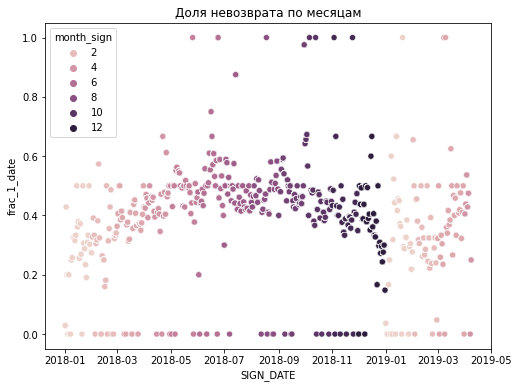

In [12]:
df = train_
df['frac_1_date'] = df.groupby('SIGN_DATE').TARGET.transform('sum') / df.groupby('SIGN_DATE').TARGET.transform('count')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='SIGN_DATE', y='frac_1_date', hue='month_sign', data=df) 
plt.title('Доля невозврата по месяцам')
plt.show()

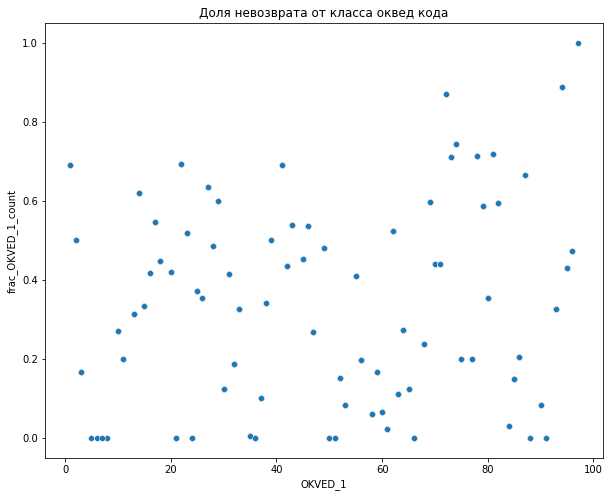

In [79]:
df = train_
df['frac_OKVED_1_count'] = df.groupby('OKVED_1').TARGET.transform('sum') / df.groupby('OKVED_1').TARGET.transform('count')
fig, ax = plt.subplots(figsize=(10,8))
b = sns.scatterplot(x='OKVED_1', y='frac_OKVED_1_count',  data=df) 
plt.title('Доля невозврата от класса оквед кода')
plt.show()

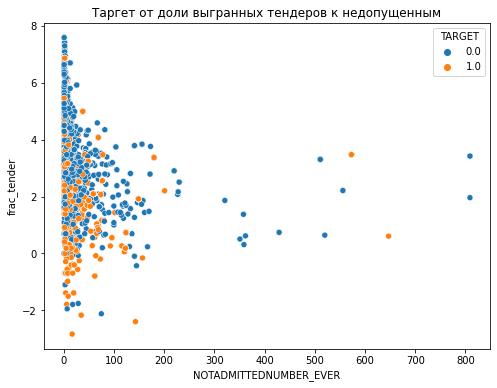

In [78]:
df = train_
df['frac_tender'] = np.log(df.WINNERNUMBER_95_EVER / df.NOTADMITTEDNUMBER_EVER)
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='NOTADMITTEDNUMBER_EVER', y='frac_tender', hue='TARGET', data=df) 
plt.title('Таргет от доли выгранных тендеров к недопущенным')
plt.show()

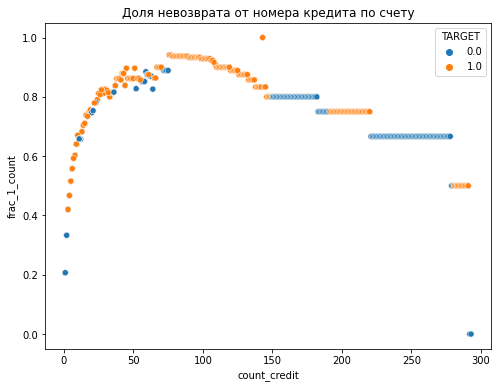

In [74]:
df = train_
df['frac_1_count'] = df.groupby('count_credit').TARGET.transform('sum') / df.groupby('count_credit').TARGET.transform('count')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='count_credit', y='frac_1_count', hue='TARGET', data=df) 
plt.title('Доля невозврата от номера кредита по счету')
plt.show()

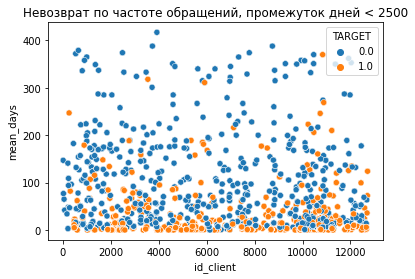

In [54]:
df = train_
sns.scatterplot(x=df['id_client'][df['mean_days'] < 2500], y=df['mean_days'][df['mean_days'] < 2500], hue=df['TARGET'][df['mean_days'] < 2500]) 
plt.title('Невозврат по частоте обращений, промежуток дней < 2500')
plt.show()

# CatBoost

In [59]:
ct = ['day_of_week_sign','month_sign','year_sign', 'OKVED_1', 'OKVED_2', 'OKVED_3'] 
features_cols = train_.drop(['TARGET'] + ct, axis='columns').select_dtypes(include=[np.number]).columns.tolist()
cat_features = list(set(train_.drop(['TARGET','pred_credit_date','TAXREGPAY_REGDATE','TAXREG_REGDATE', 'DATEFIRSTREG','BIRTHDATE','SIGN_DATE', 'SEX_NAME'], axis='columns').columns).difference(features_cols)) 

In [60]:
train_.OKVED_1 = train_.OKVED_1.astype(str).fillna('NaN')
train_.OKVED_2 = train_.OKVED_2.astype(str).fillna('NaN')
train_.OKVED_3 = train_.OKVED_3.astype(str).fillna('NaN')

In [61]:
test_.OKVED_1 = test_.OKVED_1.astype(str).fillna('NaN')
test_.OKVED_2 = test_.OKVED_2.astype(str).fillna('NaN')
test_.OKVED_3 = test_.OKVED_3.astype(str).fillna('NaN')

In [62]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_seed=228)

In [63]:
cat_features

['OKOGU_GROUP',
 'CITIZENSHIP_NAME',
 'OKATO_FED',
 'OKOPF_GROUP',
 'year_sign',
 'day_of_week_sign',
 'EGRPOINCLUDED',
 'OKFS_GROUP',
 'OKVED_1',
 'OKTMO_FED',
 'OKVED_2',
 'OKVED_CODE',
 'OKATO_REGIONCODE',
 'OKVED_3',
 'month_sign']

In [64]:
cat.fit(train_.drop(columns='TARGET')[features_cols + cat_features],train_.TARGET, cat_features=cat_features, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)[np.array(importance) > 0.5]
    feature_names = np.array(names)[np.array(importance) > 0.5]
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE > 0.5')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

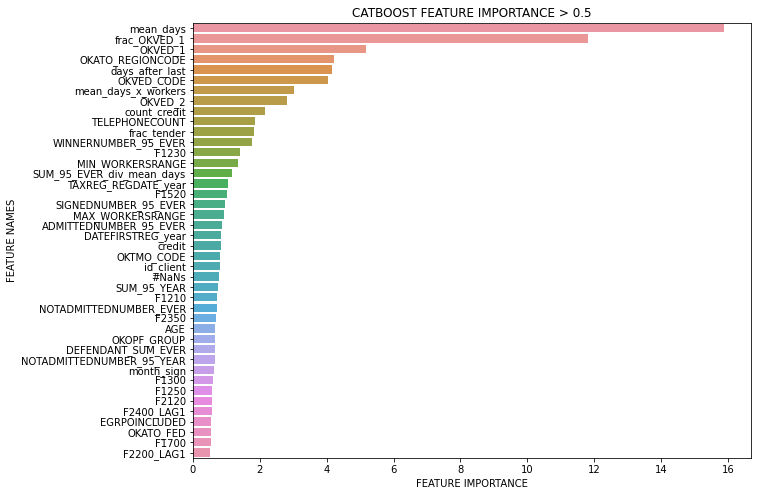

In [69]:
plot_feature_importance(cat.get_feature_importance(),cat.feature_names_,'CATBOOST')

## Топ 10 признаков:
1. `mean_days` -- через сколько обычно этот клиент в среднем берет кредит (если только одни кредит, что считаем количество дней с 1970 года)
2. `frac_OKVED_1` -- среднее значение таргета для данных двух цифр ОКВЭДа
3. `OKVED_1` -- первые две цифры ОКВЭДа
4. `OKATO_REGIONCODE` -- ОКАТО. Код региона
5. `days_after_last` -- сколько прошло дней с предыдущего кредита (если предыдущего кредита не было, то считаем количество дней с 1970 года)
6. `OKVED_CODE` -- дефолтный признак
7. `mean_days_x_workers` -- среднее количество дней до нового кредита умноженное на количество сотрудников по верхней границе
8. `OKVED_2` -- вторые две цифры ОКВЭДа
9. `count_credit` -- какой посчету кредит клиента
10. `TELEPHONECOUNT` -- Количество компаний с аналогичными телефоном

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_.TARGET, cat.predict_proba(train_.drop(columns=['TARGET',])[features_cols + cat_features])[:,1])

0.9916803542940181

In [25]:
test_['TARGET'] = cat.predict_proba(test_.drop(columns=['TARGET',])[features_cols + cat_features])[:,1]
test_[['id_contract', 'TARGET']].to_csv('submit.csv', sep=';', index=False)
test_[['id_contract', 'TARGET']].head()

,id_contract,TARGET
17887,17940,0.644479
17888,17941,0.013873
17889,17942,0.136458
17890,17946,0.811615
17891,17944,0.056788


# Описание первоначальных признаков

* `Название поля	Описание
* `id_contract`	Идентификатор контракта
* `id_client`	Идентификатор клиента
* `SIGN_DATE`	Дата подписания контракта
* `IP_flag`	Флаг ИП
* `TARGET`	Целевая переменная - факт наличия предъявления по гарантии
* `F1100`	Внеоборотные активы
* `F1110`	Нематериальные активы
* `F1150`	Основные средства
* `F1160`	Доходные вложения в материальные ценности
* `F1170`	Долгосрочные финансовые вложения
* `F1180`	Отложенные налоговые активы
* `F1190`	Прочие внеоборотные активы
* `F1200`	Оборотные активы
* `F1210`	Запасы
* `F1220`	НДС по приобретенным ценностям
* `F1230`	Дебиторская задолженность
* `F1240`	Краткосрочные финансовые вложения
* `F1250`	Дебиторская задолженность
* `F1260`	Прочие оборотные активы
* `F1300`	Капитал и резервы
* `F1310`	Уставный капитал
* `F1320`	Собственные акции, выкупленные у акционеров
* `F1350`	Добавочный капитал
* `F1360`	Резервный капитал
* `F1370`	Нераспределенная прибыль (непокрытый убыток)
* `F1400`	Долгосрочные обязательства
* `F1410`	Заёмные средства (долгосрочные)
* `F1420`	Отложенные налоговые обязательства
* `F1450`	Прочие долгосрочные обязательства
* `F1500`	Краткосрочные обязательства
* `F1510`	Заёмные средства (краткосрочные)
* `F1520`	Кредиторская задолженность
* `F1530`	Доходы будущих периодов
* `F1550`	Прочие краткосрочные обязательства
* `F1600`	Активы  всего
* `F1700`	Пассивы всего
* `F2100`	Валовая прибыль (убыток)
* `F2110`	Выручка
* `F2120`	Себестоимость продаж
* `F2200`	Прибыль (убыток) от продажи
* `F2210`	Коммерческие расходы
* `F2220`	Управленческие расходы
* `F2300`	Прибыль (убыток) до налогообложения
* `F2310`	Доходы от участия в других организациях
* `F2320`	Проценты к получению
* `F2330`	Проценты к уплате
* `F2340`	Прочие доходы
* `F2350`	Прочие расходы
* `F2400`	Чистая прибыль (убыток)
* `F2410`	Текущий налог на прибыль
* `F1150_LAG1`	Основные средства (предыдущий период)
* `F1230_LAG1`	Дебиторская задолженность (предыдущий период)
* `F1410_LAG1`	Заёмные средства (долгосрочные) (предыдущий период)
* `F1510_LAG1`	Заёмные средства (краткосрочные) (предыдущий период)
* `F1520_LAG1`	Кредиторская задолженность (предыдущий период)
* `F2110_LAG1`	Выручка (предыдущий период)
* `F2120_LAG1`	Себестоимость продаж (предыдущий период)
* `F2200_LAG1`	Прибыль (убыток) от продажи (предыдущий период)
* `F2210_LAG1`	Коммерческие расходы (предыдущий период)
* `F2220_LAG1`	Управленческие расходы (предыдущий период)
* `F2300_LAG1`	Прибыль (убыток) до налогообложения (предыдущий период)
* `F2320_LAG1`	Проценты к получению (предыдущий период)
* `F2330_LAG1`	Проценты к уплате (предыдущий период)
* `F2400_LAG1`	Чистая прибыль (убыток) (предыдущий период)
* `EGRPOINCLUDED`	Признак включения в ЕГРПО (Росстат)
* `DATEFIRSTREG`	Дата регистрации
* `OKFS_GROUP`	Группа ОКФС
* `OKOPF_GROUP`	Группа ОКОПФ
* `OKOGU_GROUP`	Группа ОКОГУ
* `OKATO_REGIONCODE`	ОКАТО. Код региона
* `OKATO_FED`	Код федерального округа по ОКАТО
* `OKTMO_CODE`	ОКТМО. Код
* `OKTMO_FED`	Код федерального округа по ОКОТМО
* `WORKERSRANGE`	Диапазон численности персонала
* `TAXREG_REGDATE`	Регистрация в ФНС. Дата регистрации
* `TAXREGPAY_REGDATE`	Регистрация в налоговом органе. Дата регистрации
* `COUNTCOOWNERFCSM`	Структура компании. Количество совладельцев (Данные компании/ФСФР)
* `COUNTCOOWNERROSSTAT`	Структура компании. Количество совладельцев (Ростат)
* `COUNTCOOWNEREGRUL`	Структура компании. Количество совладельцев (ЕГРЮЛ)
* `COUNTBRANCH`	Структура компании. Количество филиалов (Данные компании)
* `COUNTBRANCHROSSTAT`	Структура компании. Количество филиалов (Росстат)
* `COUNTBRANCHEGRUL`	Структура компании. Количество филиалов (ЕГРЮЛ)
* `TELEPHONECOUNT`	Количество компаний с аналогичными телефоном
* `MANAGERCOUNTINCOUNTRY`	Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди всех действующих компаний)
* `MANAGERCOUNTINREGION`	Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди действующих компаний, зарегистрированных в том же регионе)
* `MANAGERINNCOUNT`	Количество компаний с аналогичным ИНН руководителя (поиск по ИНН руководителя среди всех действующих компаний)
* `OKVED_CODE`	ОКВЭД
* `PLAINTIFF_CASESNUMBER_YEAR`	Участие в арбитражных делах в качестве истца. Количество дел (за последний год)
* `PLAINTIFF_SUM_YEAR`	Участие в арбитражных делах в качестве истца. Сумма, руб. (за последний год)
* `DEFENDANT_CASESNUMBER_YEAR`	Участие в арбитражных делах в качестве ответчика. Количество дел (за последний год)
* `DEFENDANT_SUM_YEAR`	Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за последний год)
* `THIRDOROTHERPERSON_YEAR`	Участие в арбитражных делах в качестве третьего лица. (за последний год)
* `PLAINTIFF_CASESNUMBER_EVER`	Участие в арбитражных делах в качестве истца. Количество дел (за все время)
* `PLAINTIFF_SUM_EVER`	Участие в арбитражных делах в качестве истца. Сумма, руб. (за все время)
* `DEFENDANT_CASESNUMBER_EVER`	Участие в арбитражных делах в качестве ответчика. Количество дел (за все время)
* `DEFENDANT_SUM_EVER`	Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за все время)
* `THIRDOROTHERPERSON_EVER`	Участие в арбитражных делах в качестве третьего лица. (за все время)
* `ADMITTEDNUMBER_233_YEAR`	Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 223)
* `NOTADMITTEDNUMBER_233_YEAR`	Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 223)
* `WINNERNUMBER_233_YEAR`	Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 223)
* `SIGNEDNUMBER_233_YEAR`	Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 223)
* `SUM_233_YEAR`	Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 223)
* `ADMITTEDNUMBER_233_EVER`	Данные о тендерах за все время. Число допусков к тендеру (ФЗ 223)
* `NOTADMITTEDNUMBER_233_EVER`	Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 223)
* `WINNERNUMBER_233_EVER`	Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 223)
* `SIGNEDNUMBER_233_EVER`	Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 223)
* `SUM_233_EVER`	Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 223)
* `ADMITTEDNUMBER_95_YEAR`	Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 94)
* `NOTADMITTEDNUMBER_95_YEAR`	Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 94)
* `WINNERNUMBER_95_YEAR`	Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 94)
* `SIGNEDNUMBER_95_YEAR`	Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 94)
* `SUM_95_YEAR`	Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 94)
* `ADMITTEDNUMBER_95_EVER`	Данные о тендерах за все время. Число допусков к тендеру (ФЗ 94)
* `NOTADMITTEDNUMBER_EVER`	Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 94)
* `WINNERNUMBER_95_EVER`	Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 94)
* `SIGNEDNUMBER_95_EVER`	Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 94)
* `SUM_95_EVER`	Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 94)
* `FLAG_DISQUALIFICATION`	Наличие руководителя компании, дисквалифицированного когда-либо
* `COUNT_CHANGE_YEAR`	Количество изменений в наименовании и организационно-правовой форме за последний год
* `COUNT_CHANGE_EVER`	Количество изменений в наименовании и организационно-правовой форме за все время
* `BIRTHDATE`	Дата рождения
* `AGE`	Возраст
* `SEX_NAME`	Пол
* `CITIZENSHIP_NAME`	Гражданство